In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

In [69]:
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)

In [70]:
from fastai.imports import *
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *

In [71]:
PATH = '/home/ubuntu/data/dogscats/'
size = 224

In [72]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [73]:
files = !ls {PATH}valid/cats | head 
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

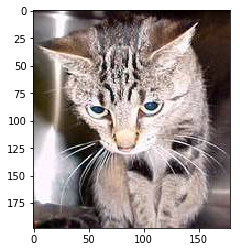

In [74]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [75]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(f_model=resnet34,sz=size))
learn = ConvLearner.pretrained(arch, data, precompute=True) 
learn.fit(0.01, 3)

A Jupyter Widget

[ 0.       0.03887  0.02746  0.98877]                         
[ 1.       0.03672  0.0247   0.99023]                         
[ 2.       0.0336   0.02768  0.98926]                         



In [76]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [77]:
data.classes

['cats', 'dogs']

In [78]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [79]:
log_preds[:10]

array([[ -0.     , -12.4272 ],
       [ -0.00209,  -6.17045],
       [ -0.00001, -11.30602],
       [ -0.00187,  -6.28384],
       [ -0.     , -12.37906],
       [ -0.00016,  -8.70893],
       [ -0.     , -12.69294],
       [ -0.0001 ,  -9.22112],
       [ -0.00017,  -8.67704],
       [ -0.     , -13.09739]], dtype=float32)

In [80]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

In [81]:
def rand_by_mask(mask): 
    return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): 
    return rand_by_mask((preds == data.val_y)==is_correct)


In [82]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [83]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [84]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [85]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Correctly classified


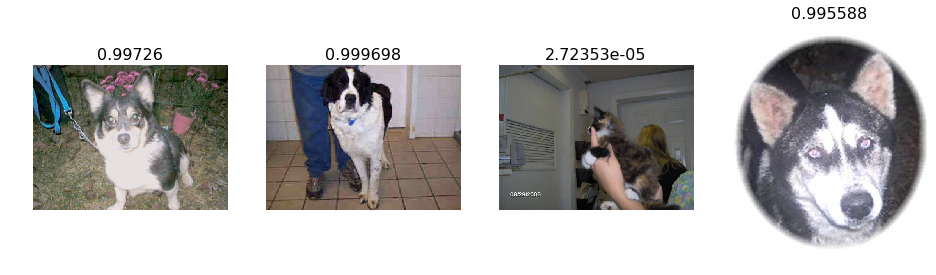

In [86]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


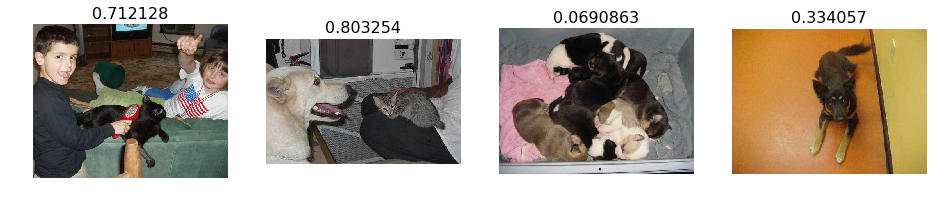

In [87]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most incorrect dogs


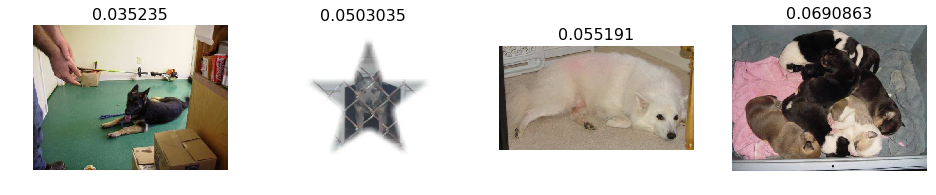

In [88]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most correct dogs


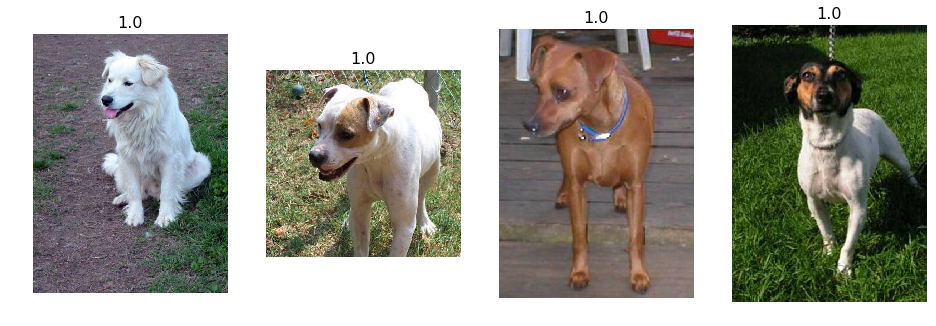

In [89]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most uncertain predictions


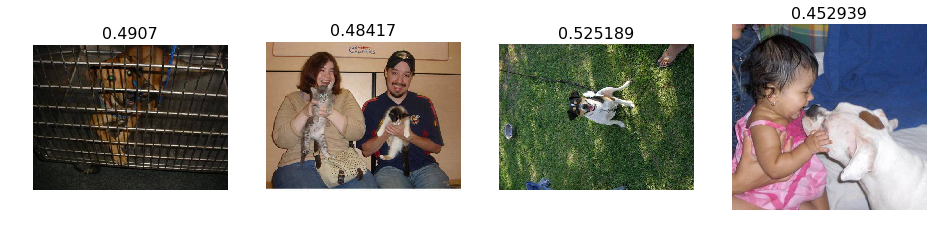

In [90]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [96]:
sz=224
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [97]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [98]:
ims = np.stack([get_augs() for i in range(6)])

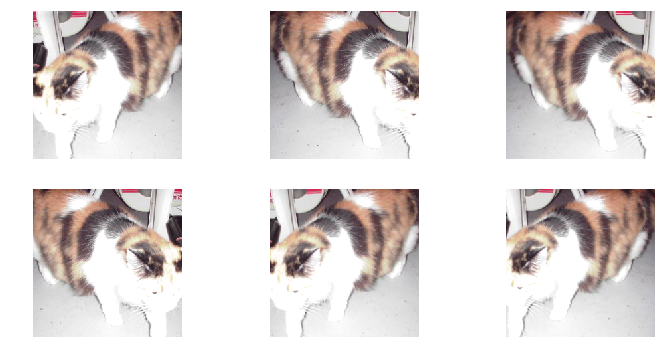

In [99]:
plots(ims, rows=2)

In [100]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [101]:
learn.fit(1e-2, 1)

A Jupyter Widget

[ 0.       0.04305  0.03045  0.98926]                         



In [102]:
learn.precompute=False

In [103]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.04494  0.02939  0.98877]                         
[ 1.       0.04693  0.02777  0.98877]                         
[ 2.       0.04194  0.03065  0.98828]                         



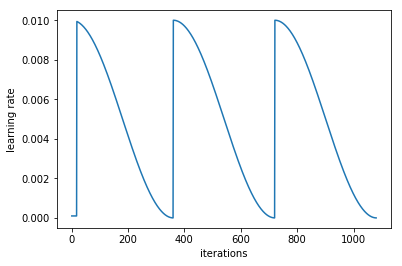

In [110]:
learn.sched.plot_lr()

In [111]:
learn.save('224_lastlayer')
learn.load('224_lastlayer')
learn.unfreeze()

In [112]:
lr=np.array([1e-4,1e-3,1e-2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.05708  0.02611  0.98926]                         
[ 1.       0.03952  0.02141  0.9917 ]                         
[ 2.       0.0276   0.02011  0.9917 ]                         
[ 3.       0.0273   0.02199  0.99072]                         
[ 4.       0.02229  0.01919  0.99316]                         
[ 5.       0.02399  0.01775  0.99268]                         
[ 6.       0.02133  0.01826  0.99268]                         



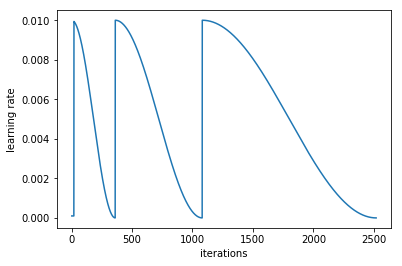

In [113]:
learn.sched.plot_lr()

In [114]:
learn.save('224_all')
learn.load('224_all')

In [115]:
log_preds,y = learn.TTA()
accuracy(log_preds,y)

0.995

# Confusion Matrix

In [116]:
preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[996   4]
 [  6 994]]


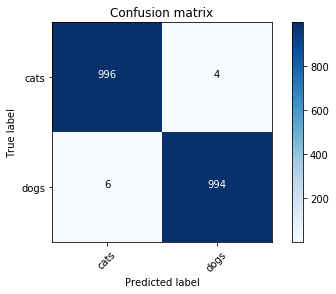

In [117]:
plot_confusion_matrix(cm, data.classes)